In [45]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [46]:
torch.manual_seed(42)

In [47]:
torch.backends.cudnn.enabled = False

In [48]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.dropout = nn.Dropout(0.5)
        self.lin1 = nn.Linear(320,50)
        self.lin2 = nn.Linear(50,10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [49]:
model = Model()
lr = 1e-3
batch_size = 256
epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.99)
device = torch.device("cpu")
model.to(device)

Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (lin1): Linear(in_features=320, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=10, bias=True)
)

In [50]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_trainset = datasets.MNIST('../data/train', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST('../data/test', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(list(zip(mnist_trainset.data, mnist_trainset.targets)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(list(zip(mnist_testset.data, mnist_testset.targets)), batch_size=batch_size, shuffle=True, drop_last=True)

In [51]:
for x,y in train_loader:
    print(x.shape)
    break

torch.Size([256, 28, 28])


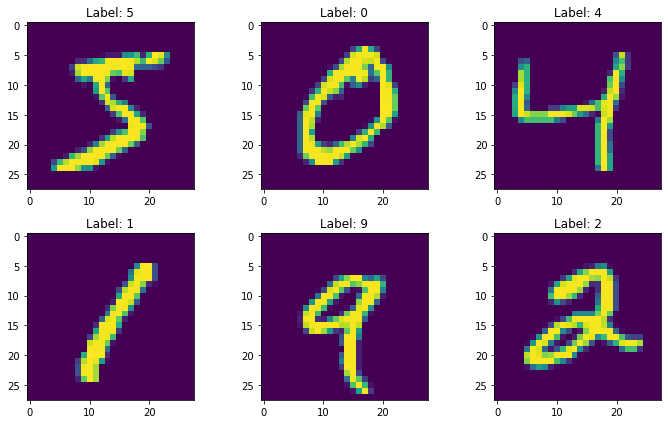

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(10,6))
for i in range(6):
    axes[i//3, i%3].imshow(mnist_trainset.data[i])
    axes[i//3, i%3].set_title('Label: {}'.format(mnist_trainset.targets[i]))
plt.tight_layout()
plt.show()

In [53]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    
    model.train()
    for images, targets in tqdm(train_loader):
        images, targets = images.to(device).float(), targets.to(device)
        images = images.reshape(batch_size,1,28,28)
        optimizer.zero_grad()
        output = model(images)
        loss = F.nll_loss(output, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
    model.eval()
    temp = []
    for images, targets in tqdm(test_loader):
        images, targets = images.to(device).float(), targets.to(device)
        images = images.reshape(batch_size,1,28,28)
        output = model(images)
        loss = F.nll_loss(output, targets)
        temp.append(loss.item())
    test_loss.append(np.mean(temp))

100%|██████████| 39/39 [00:00<00:00, 87.33it/s]


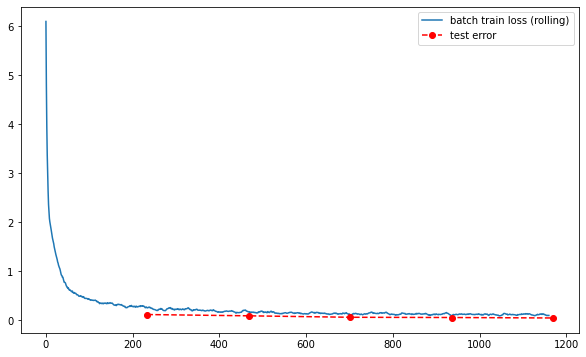

In [54]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(train_loss, np.ones(10)/10, mode='valid'), label='batch train loss (rolling)')
plt.plot([len(train_loader)*epoch for epoch in range(1,epochs+1)], test_loss, "--o", color="red", label='test error')
plt.legend()
plt.show()

In [55]:
torch.save(model.state_dict(), 'models/base.pt')

In [56]:
loaded_model = torch.load('models/base.pt')

In [57]:
model.eval()
sample = mnist_testset.data[:10].reshape(10,1,28,28).float()
out = model(sample)
pred = torch.argmax(out, dim=1)

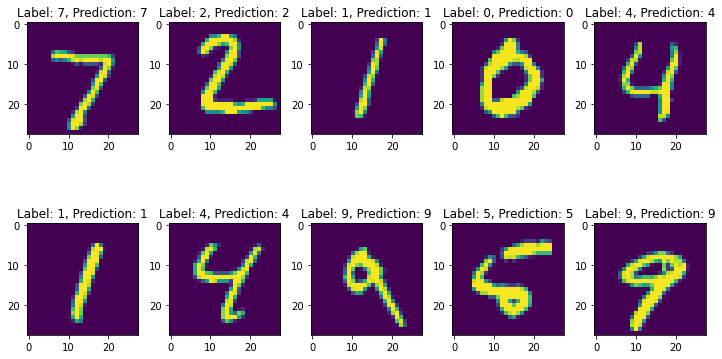

In [58]:
fig, axes = plt.subplots(2, 5, figsize=(10,6))
for i in range(10):
    axes[i//5, i%5].imshow(mnist_testset.data[i])
    axes[i//5, i%5].set_title('Label: {}, Prediction: {}'.format(mnist_testset.targets[i], pred[i]))
plt.tight_layout()
plt.show()

In [59]:
import os
import cv2

DIR = 'mnist_drawn'

images, labels = [], []

#iterate over greek alphabet images
for file in os.listdir(DIR):
    if file.endswith('.png'):
        #read image
        img = cv2.imread(DIR+'/'+file)
        #resize to 28x28
        img = cv2.resize(img, (28,28))
        #convert greyscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #convert to channel first
        img = img.reshape(-1, 28, 28)
        #get label
        label = file.split('_')[0]
        
        #store as image and label
        images.append(img)
        labels.append(label)

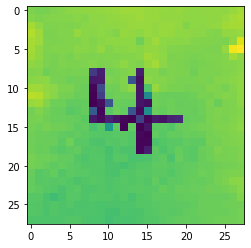

In [60]:
#verify that drawk images resemble reasonable numbers
plt.imshow(images[1].reshape(28,28))

In [61]:
#read drawn images, make predictions and score
corr, wrong = 0, 0
for image, label in zip(images, labels):
    out = torch.argmax(model(torch.tensor([image], dtype=torch.float32)), dim=1).item()
    truth = label.split('.')[0]
    if int(out)==int(truth):
        corr+=1
    else:
        wrong+=1
        
print("Acc on Drawn Images: {}".format(round(corr/(corr+wrong), 3)))

Acc on Drawn Images: 0.111
